## Load in required libraries and API keys

In [66]:
import json
import pickle
import operator
import time
import os

import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

with open('config.json') as json_data:
    d = json.load(json_data)
    DRIBBBLE_API_KEY = d['dribbble-key']

Idea of cliches in data
- Kapil might try to scrape out all the users...

Interesting questions about rebounds:
- If you get only one rebound, how often are these self-rebound?
- Difference tags among rebounded and non-rebounded work

Other interesting things
- Reciprocity in comments (if I comment on someone, do they comment back?) --> use adj matrix with all people who have commented on other people's work
- Is a person more likely to give more comments if they get more comments? 

## Pulling all Shots from API

In [3]:
all_shots = []
all_shots_filename = 'all_shots.dat'

# load in from local file if exists, otherwise pull from API
if os.path.isfile(all_shots_filename):
    with open(all_shots_filename, 'rb') as f:
        all_shots = pickle.load(f)
else:
    page_number = 1
    while True:    
        print 'Current page: ' + str(page_number)
        shots_per_page_response = requests.get('https://api.dribbble.com/v1/shots', 
                                               headers={'Authorization': 'Bearer ' + DRIBBBLE_API_KEY},
                                               params={'timeframe': 'ever', 'page': page_number, 'per_page': 100})

        if shots_per_page_response.status_code == 200:
            all_shots.extend(shots_per_page_response.json())
            page_number += 1
        else:
            break

    with open(all_shots_filename, 'wb') as f:
        pickle.dump(all_shots, f)

In [4]:
shot_data = []
for shot in all_shots:
    current_data = {
        'rebounds': shot['rebounds_count'],
        'is_rebound': shot['rebounds_count'] > 0,
        'tags': shot['tags'],
        'tag_count': len(shot['tags']),
        'follower_count': shot['user']['followers_count'],
        'following_count': shot['user']['followings_count'],
        'views': shot['views_count'],
        'likes': shot['likes_count'],
        'comment_count': shot['comments_count'],
        'is_pro': shot['user']['pro']
    }
    
    shot_data.append(current_data)

## Fetching all Rebounds for all Shots from API

In [10]:
shots_with_rebounds = 0
for shot in all_shots:
    if shot['rebounds_count'] != 0:
        shots_with_rebounds += 1

print 'Number of Shots with Rebounds: ' + str(shots_with_rebounds)

Number of Shots with Rebounds: 1682


In [11]:
all_rebounds = []
query_count = 0
all_rebounds_filename = 'all_rebounds.dat'

# load in from local file if exists, otherwise pull from API
if os.path.isfile(all_rebounds_filename):
    with open(all_rebounds_filename, 'rb') as f:
        all_rebounds = pickle.load(f)
else:
    for shot in all_shots:
        if shot['rebounds_count'] > 0:
            # see if rebound is by same user
            current_rebounds = requests.get(shot['rebounds_url'], 
                                           headers={'Authorization': 'Bearer ' + DRIBBBLE_API_KEY}).json()

            all_rebounds.extend(current_rebounds)

            # if 60 requests have been made, wait for rate limiting to stop
            query_count += 1
            if query_count > 0 and query_count % 60 == 0:
                print 'Progress: ' + str(query_count) + '...pausing 1 min for throttling.'
                time.sleep(60)

    with open(all_rebounds_filename, 'wb') as f:
        pickle.dump(all_rebounds, f)

print 'Total number of Rebounds: ' + str(len(all_rebounds))

Total number of Rebounds: 3616


## Exploratory graphing

In [86]:
# create data frame for shots to simplify plotting
shot_data_df = pd.DataFrame(shot_data)
del shot_data_df['tags']
col_ordering = ['comment_count', 'follower_count', 'following_count', 'is_pro', \
                'likes', 'tag_count', 'views', 'is_rebound',  'rebounds']
shot_data_df = shot_data_df[col_ordering]

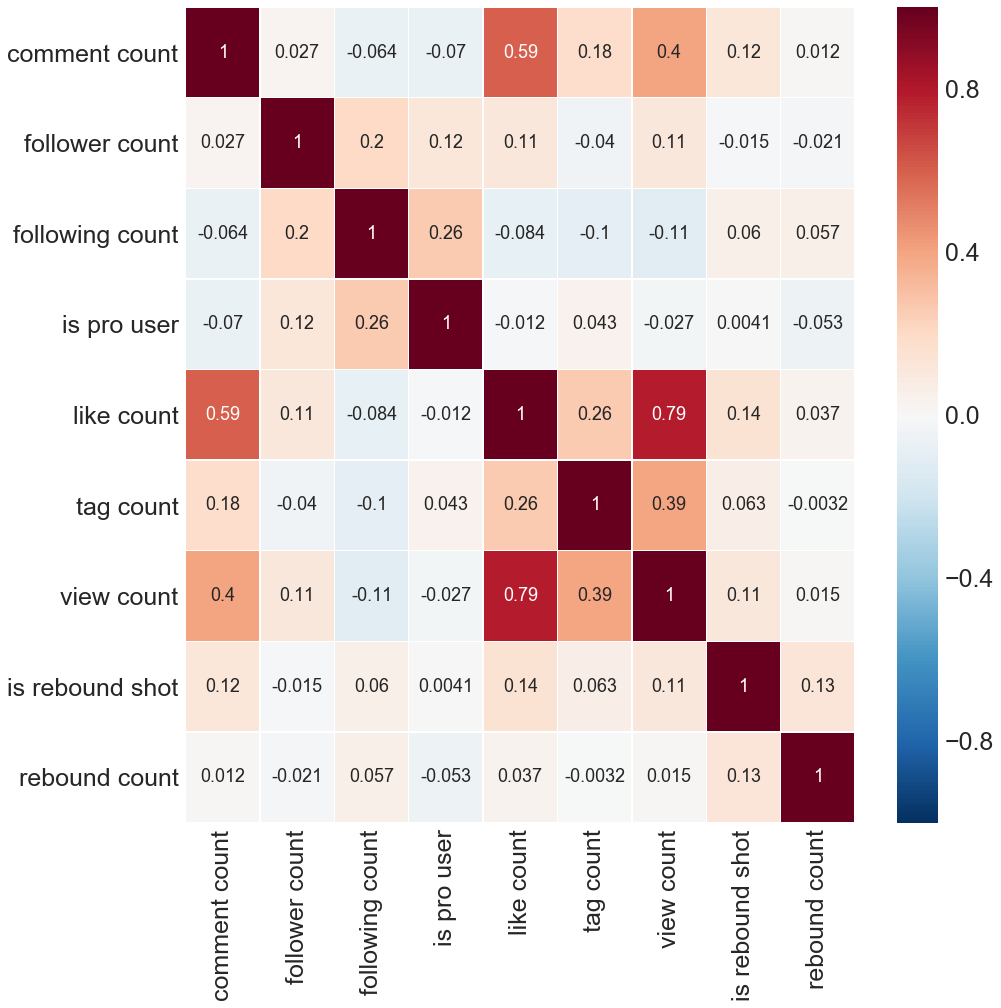

In [88]:
shot_corr = shot_data_df.corr()
shot_corr_tick_labels = ['comment count', 'follower count', 'following count', 'is pro user', \
                         'like count', 'tag count', 'view count', 'is rebound shot', 'rebound count']

fig, ax = plt.subplots(figsize=(15, 15))  
sns.set(font_scale=2.5)
sns.heatmap(shot_corr, xticklabels=shot_corr_tick_labels, yticklabels=shot_corr_tick_labels, \
            linewidths=.5, ax=ax, annot=True, annot_kws={'size': 18})

## Relationship between Rebounds and tags

In [133]:
rebound_tag_counts = {}
non_rebound_tag_counts = {}

for shot in shot_data:
    if shot['is_rebound']:
        for tag in shot['tags']:
            if tag in rebound_tag_counts:
                rebound_tag_counts[tag] += 1
            else:
                rebound_tag_counts[tag] = 1
    else:
        for tag in shot['tags']:
            if tag in non_rebound_tag_counts:
                non_rebound_tag_counts[tag] += 1
            else:
                non_rebound_tag_counts[tag] = 1                

In [134]:
sorted_rebound_tag_counts = sorted(rebound_tag_counts.items(), key=operator.itemgetter(1), reverse=True)
sorted_non_rebound_tag_counts = sorted(non_rebound_tag_counts.items(), key=operator.itemgetter(1), reverse=True)

In [135]:
sorted_rebound_tag_counts

[(u'illustration', 414),
 (u'ui', 382),
 (u'icon', 282),
 (u'app', 214),
 (u'logo', 209),
 (u'ux', 207),
 (u'ios', 191),
 (u'animation', 184),
 (u'vector', 175),
 (u'design', 163),
 (u'flat', 161),
 (u'icons', 152),
 (u'iphone', 139),
 (u'gif', 134),
 (u'web', 116),
 (u'clean', 97),
 (u'interface', 96),
 (u'mobile', 85),
 (u'website', 83),
 (u'typography', 78),
 (u'minimal', 75),
 (u'branding', 73),
 (u'sketch', 67),
 (u'dashboard', 65),
 (u'identity', 65),
 (u'mark', 63),
 (u'3d', 62),
 (u'character', 61),
 (u'space', 57),
 (u'simple', 56),
 (u'type', 55),
 (u'free', 55),
 (u'navigation', 55),
 (u'texture', 55),
 (u'apple', 52),
 (u'blue', 50),
 (u'freebie', 48),
 (u'psd', 47),
 (u'motion', 46),
 (u'concept', 45),
 (u'button', 45),
 (u'card', 44),
 (u'layout', 38),
 (u'badge', 38),
 (u'map', 38),
 (u'music', 36),
 (u'menu', 36),
 (u'graph', 36),
 (u'social', 36),
 (u'after effects', 35),
 (u'photoshop', 35),
 (u'sun', 34),
 (u'ipad', 34),
 (u'car', 33),
 (u'white', 33),
 (u'material',

In [136]:
sorted_non_rebound_tag_counts

[(u'illustration', 786),
 (u'ui', 649),
 (u'animation', 530),
 (u'logo', 402),
 (u'app', 397),
 (u'icon', 392),
 (u'design', 364),
 (u'ux', 354),
 (u'gif', 323),
 (u'ios', 301),
 (u'flat', 279),
 (u'web', 278),
 (u'typography', 232),
 (u'iphone', 218),
 (u'branding', 217),
 (u'icons', 202),
 (u'website', 197),
 (u'vector', 183),
 (u'interface', 177),
 (u'motion', 174),
 (u'sketch', 170),
 (u'mobile', 148),
 (u'character', 147),
 (u'clean', 140),
 (u'identity', 139),
 (u'minimal', 129),
 (u'3d', 119),
 (u'dashboard', 116),
 (u'texture', 108),
 (u'type', 105),
 (u'space', 100),
 (u'mark', 95),
 (u'paper', 93),
 (u'vintage', 91),
 (u'layout', 88),
 (u'graph', 87),
 (u'after effects', 86),
 (u'focus lab', 85),
 (u'logotype', 81),
 (u'ipad', 80),
 (u'badge', 79),
 (u'blue', 79),
 (u'game', 78),
 (u'simple', 76),
 (u'wood', 74),
 (u'menu', 73),
 (u'lettering', 73),
 (u'landing', 73),
 (u'print', 71),
 (u'interaction', 70),
 (u'navigation', 70),
 (u'retro', 69),
 (u'web design', 67),
 (u'land

## Finding self-rebounds
Let us define self-rebounds to be when a user rebounds a post they have made themselves and the self-rebound rate to be the proportion of rebounds done by the original poster themselves.

For Shots who only have 1 rebound, how many of them are self-rebounds?

In [30]:
single_rebound_count = 0
single_self_rebound_count = 0

for shot in all_shots:
    if shot['rebounds_count'] == 1:
        # see if rebound is by same user
        current_user = shot['user']['id']
        shot_id = shot['id']

        for rebound in all_rebounds:
            rebound_from_shot_id = int(rebound['rebound_source_url'].replace('https://api.dribbble.com/v1/shots/', ''))
            
            if rebound['user']['id'] == current_user and shot_id == rebound_from_shot_id:
                single_self_rebound_count += 1
        
        single_rebound_count += 1

In [31]:
print 'Number of Shots with 1 Rebound: ' + str(single_rebound_count)
print 'Number of Self-Rebounds for Shots with only 1 Rebound: ' + str(single_self_rebound_count)
print 'Self-Rebound rate (when Shot only has 1 Rebound): ' + str(round(100 * single_self_rebound_count / float(single_rebound_count), 3)) + '%'

Number of Shots with 1 Rebound: 1036
Number of Self-Rebounds for Shots with only 1 Rebound: 463
Self-Rebound rate (when Shot only has 1 Rebound): 44.691%


For those who have more than 1 rebound, how many Shots have self-rebounds?

In [32]:
multiple_rebound_count = 0
multiple_self_rebound_count = 0

for shot in all_shots:
    if shot['rebounds_count'] > 1:
        # see if rebound is by same user
        current_user = shot['user']['id']
        shot_id = shot['id']

        for rebound in all_rebounds:
            rebound_from_shot_id = int(rebound['rebound_source_url'].replace('https://api.dribbble.com/v1/shots/', ''))
            
            if rebound['user']['id'] == current_user and shot_id == rebound_from_shot_id:
                multiple_self_rebound_count += 1
        
        multiple_rebound_count += 1

In [33]:
print 'Number of Shots with > 1 Rebound: ' + str(multiple_rebound_count)
print 'Number of Self-Rebounds for Shots with > 1 Rebound: ' + str(multiple_self_rebound_count)
print 'Self-Rebound rate (when Shot has > 1 Rebound): ' + str(round(100 * multiple_self_rebound_count / float(multiple_rebound_count), 3)) + '%'

Number of Shots with > 1 Rebound: 646
Number of Self-Rebounds for Shots with > 1 Rebound: 495
Self-Rebound rate (when Shot has > 1 Rebound): 76.625%


What about generally? How often do people Rebound their own work?

In [34]:
rebound_count = 0
self_rebound_count = 0

for shot in all_shots:
    if shot['rebounds_count'] > 0:
        # see if rebound is by same user
        current_user = shot['user']['id']
        shot_id = shot['id']

        for rebound in all_rebounds:
            rebound_from_shot_id = int(rebound['rebound_source_url'].replace('https://api.dribbble.com/v1/shots/', ''))
            
            if rebound['user']['id'] == current_user and shot_id == rebound_from_shot_id:
                self_rebound_count += 1
        
        rebound_count += 1

In [35]:
print 'Number of Shots with Rebounds: ' + str(rebound_count)
print 'Number of Rebounds by User who Posted Shots: ' + str(self_rebound_count)
print 'Percentage of Self-Rebounds: ' + str(round(100 * self_rebound_count / float(rebound_count), 3)) + '%'

Number of Shots with Rebounds: 1682
Number of Rebounds by User who Posted Shots: 958
Percentage of Self-Rebounds: 56.956%


### Diving deeper into 1 Rebound Shots
Above we see that approximately 45% of Rebounds on Shots with 1 Rebounds are self-rebounds. What are the other rebounds? Are there characteristics of the Shots that differ among these two groups?